# Finetune VGG16


With 224x224 melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'vgg16_224'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.vgg16(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.classifier[-1].parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 20

C:\Users\profi\AppData\Local\Temp\ipykernel_11908\29953048.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.70it/s, Loss=1.7422477006912231, Elapsed=27.2289s, ETA=0.0000s]  


Epoch 1 completed in 107.5856s
Train Loss: 1.4638255738109522 - Train Accuracy: 40.053368309174374
Validation Loss: 1.2704858175913494 - Validation Accuracy: 45.74715069649641

Epoch 2/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.4323580265045166, Elapsed=26.5107s, ETA=0.0000s] 


Epoch 2 completed in 103.9566s
Train Loss: 1.3664346240848475 - Train Accuracy: 42.9433979331087
Validation Loss: 1.2366176954905193 - Validation Accuracy: 48.35373575348248

Epoch 3/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.97it/s, Loss=1.5278159379959106, Elapsed=26.1217s, ETA=0.0000s] 


Epoch 3 completed in 103.4596s
Train Loss: 1.347760780698302 - Train Accuracy: 43.73487709459307
Validation Loss: 1.1902610301971435 - Validation Accuracy: 49.69396369776277

Epoch 4/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.95it/s, Loss=1.5258320569992065, Elapsed=26.1009s, ETA=0.0000s] 


Epoch 4 completed in 103.2661s
Train Loss: 1.3455642396314984 - Train Accuracy: 43.91126387915244
Validation Loss: 1.1813885418574015 - Validation Accuracy: 47.298438159560995

Epoch 5/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.93it/s, Loss=1.5900970697402954, Elapsed=26.0767s, ETA=0.0000s] 


Epoch 5 completed in 103.2739s
Train Loss: 1.3287687859783284 - Train Accuracy: 44.689174826439924
Validation Loss: 1.2185136008262634 - Validation Accuracy: 48.089911355002116

Epoch 6/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.89it/s, Loss=1.4319394826889038, Elapsed=26.1101s, ETA=0.0000s] 


Epoch 6 completed in 103.4075s
Train Loss: 1.3334809965480958 - Train Accuracy: 44.53992447027431
Validation Loss: 1.186404100259145 - Validation Accuracy: 47.09793161671592

Epoch 7/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.92it/s, Loss=1.366694688796997, Elapsed=26.1891s, ETA=0.0000s]  


Epoch 7 completed in 103.3065s
Train Loss: 1.3328392140438101 - Train Accuracy: 44.548969946405556
Validation Loss: 1.1992361164093017 - Validation Accuracy: 48.427606585056985

Epoch 8/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.89it/s, Loss=1.5367833375930786, Elapsed=26.2549s, ETA=0.0000s] 


Epoch 8 completed in 103.4436s
Train Loss: 1.3265267669120966 - Train Accuracy: 44.725356730964926
Validation Loss: 1.1829273104667664 - Validation Accuracy: 46.707471506964964

Epoch 9/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.95it/s, Loss=1.5587953329086304, Elapsed=26.0170s, ETA=0.0000s] 


Epoch 9 completed in 103.3995s
Train Loss: 1.3280478970852891 - Train Accuracy: 44.72987946903055
Validation Loss: 1.1740999261538188 - Validation Accuracy: 51.72013507809202

Epoch 10/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.83it/s, Loss=1.5431581735610962, Elapsed=26.0990s, ETA=0.0000s] 


Epoch 10 completed in 104.0905s
Train Loss: 1.325245066185218 - Train Accuracy: 44.861038872933676
Validation Loss: 1.179089414278666 - Validation Accuracy: 50.16884761502743

Epoch 11/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.89it/s, Loss=1.6963608264923096, Elapsed=26.2716s, ETA=0.0000s] 


Epoch 11 completed in 104.2476s
Train Loss: 1.326281060373163 - Train Accuracy: 44.66882250514461
Validation Loss: 1.1817427786191304 - Validation Accuracy: 51.24525116082735

Epoch 12/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.2974647283554077, Elapsed=26.2877s, ETA=0.0000s] 


Epoch 12 completed in 103.4868s
Train Loss: 1.3261930515311358 - Train Accuracy: 44.76832274258836
Validation Loss: 1.1698180508613587 - Validation Accuracy: 48.10046433094133

Epoch 13/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.319566249847412, Elapsed=26.2070s, ETA=0.0000s]  


Epoch 13 completed in 103.7677s
Train Loss: 1.32391359420181 - Train Accuracy: 44.76153863548993
Validation Loss: 1.1549462938308717 - Validation Accuracy: 48.438159560996205

Epoch 14/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.4604424238204956, Elapsed=26.3728s, ETA=0.0000s] 


Epoch 14 completed in 103.6136s
Train Loss: 1.330632292121821 - Train Accuracy: 44.73666357612899
Validation Loss: 1.1742605352401734 - Validation Accuracy: 50.08442380751372

Epoch 15/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.92it/s, Loss=1.4030729532241821, Elapsed=26.1675s, ETA=0.0000s] 


Epoch 15 completed in 103.5455s
Train Loss: 1.3214475906997747 - Train Accuracy: 44.818072861310235
Validation Loss: 1.178863880634308 - Validation Accuracy: 47.14014352047277

Epoch 16/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.94it/s, Loss=1.5066359043121338, Elapsed=26.0095s, ETA=0.0000s] 


Epoch 16 completed in 103.3060s
Train Loss: 1.3336193620124994 - Train Accuracy: 44.80224327808055
Validation Loss: 1.157502256234487 - Validation Accuracy: 50.42211903756859

Epoch 17/20


Validating: 100%|██████████| 75/75 [00:14<00:00,  5.04it/s, Loss=1.4070566892623901, Elapsed=25.8353s, ETA=0.0000s] 


Epoch 17 completed in 103.2938s
Train Loss: 1.330620184110079 - Train Accuracy: 44.62359512448836
Validation Loss: 1.1624552726745605 - Validation Accuracy: 47.50949767834529

Epoch 18/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.94it/s, Loss=1.3213409185409546, Elapsed=26.1414s, ETA=0.0000s] 


Epoch 18 completed in 103.8638s
Train Loss: 1.3168857087289667 - Train Accuracy: 45.27034666787273
Validation Loss: 1.172811176776886 - Validation Accuracy: 48.98691430983537

Epoch 19/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.92it/s, Loss=1.5924484729766846, Elapsed=26.5800s, ETA=0.0000s] 


Epoch 19 completed in 103.6615s
Train Loss: 1.326508871737243 - Train Accuracy: 44.95149363424617
Validation Loss: 1.1857109967867534 - Validation Accuracy: 50.89700295483326

Epoch 20/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.92it/s, Loss=1.2618231773376465, Elapsed=26.2131s, ETA=0.0000s] 


Epoch 20 completed in 105.0658s
Train Loss: 1.3320151302166756 - Train Accuracy: 44.899482146491486
Validation Loss: 1.1579430961608888 - Validation Accuracy: 47.81553398058252



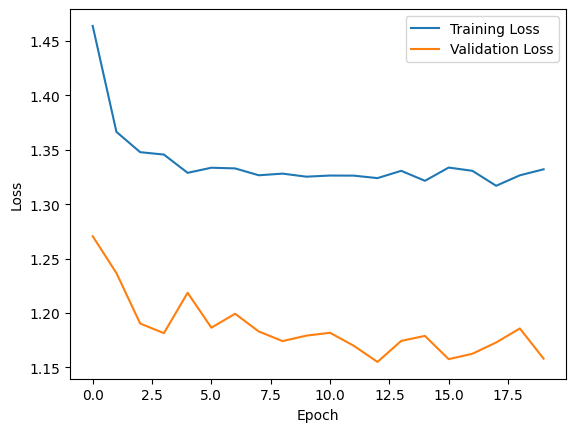

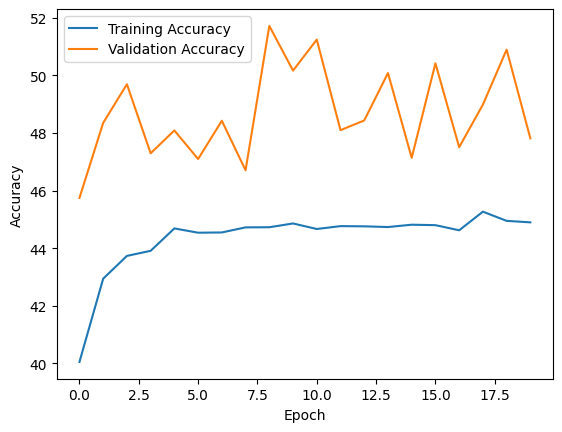

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evalaute best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_11908\3256607076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:27<00:00,  2.73it/s]

Test Accuracy: 0.5135
Test Precision: 0.5572
Test Recall: 0.5135
Test F1-score: 0.4988

              precision    recall  f1-score   support

       Anger       0.41      0.68      0.51       916
       Bored       0.68      0.72      0.70      1098
     Disgust       0.36      0.62      0.46       291
        Fear       0.29      0.61      0.40       308
       Happy       0.65      0.24      0.35      1914
     Neutral       0.57      0.38      0.45      2226
    Question       0.48      0.82      0.60      1139
         Sad       0.59      0.50      0.54       857
    Surprise       0.53      0.59      0.56       728

    accuracy                           0.51      9477
   macro avg       0.51      0.57      0.51      9477
weighted avg       0.56      0.51      0.50      9477



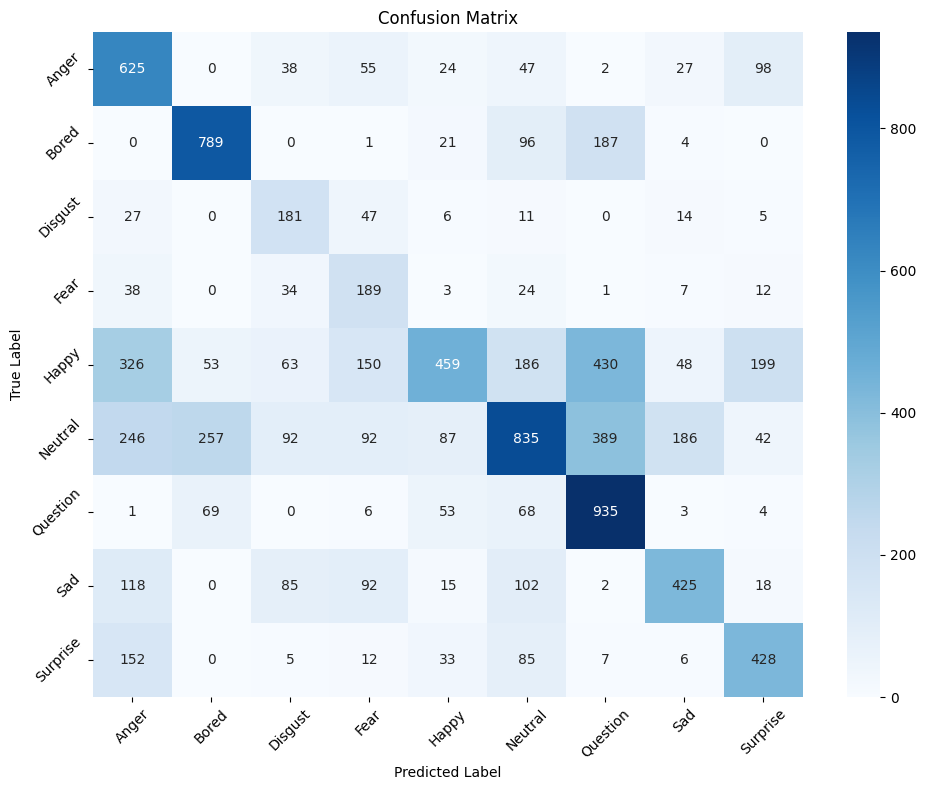

In [19]:
# Load and get predictions from the bets model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)